# Performing raster stats on remote datasets

## Scenario
Your uncle is moving to Tucson from New York City and he is deathly afraid of all the desert creatures he has heard about. He has asked you to help him find a neighborhood that is well-lit so that he can be sure to see any venomous creatures which might be lurking about. You googled 'well-lit neighborhoods in Tucson' but nothing came up. Luckily, you are a GIS professional and you know exactly what to do. With a neighborhoods polygon and a streetlights dataset you can simply do some zonal stats and figure out how much ambient light there is in each neighborhood and simply recommend those to your uncle and his realtor.


## Overview
This Jupyter Notebooks walks you through some basic spatial analysis using the `geopandas`, `numpy`, and `rasterstats` Python libraries.

In this tutorial you will learn how to:

- acquire spatial data from a remote resource as a GeoPandas `DataFrame`
- inspect a GeoPandas `DataFrame`
- visualize a GeoPandas `DataFrame`
- replace null values in a `DataFrame` attribute table
- create a heat map from points dataset using `numpy`
- create a raster (GeoTIFF) from scratch using a numpy array
- perform zonal stats using a raster and a vector with the `rasterstats` library
- sort a GeoPandas `DataFrame`

The data you will be using will be from the City of Tucson Open GIS Data website: 
- (Streetlights)[http://gisdata.tucsonaz.gov/datasets/streetlights-city-of-tucson-open-data]
- (Neighborhood Associations)[http://data-cotgis.opendata.arcgis.com/datasets/neighborhood-associations-open-data]

Don't download the data now; you will do that programmatically below.

## Install python libraries
Your jupyter environment (aka `kernel` is unlikely to have these libraries installed so you will have to install them yourself. The process is different depending on which package manager you are using. The cell below contains the command to install these for `conda`; if you are using `pip`, then replace the cell contents with the section below for `pip` users:

## For `conda` users
```
import sys
!conda install --yes --prefix {sys.prefix} rasterstats requests scipy rasterio numpy pandas geopandas matplotlib
```
### For `pip` users:
```
import sys
!{sys.executable} -m pip install rasterstats requests scipy rasterio numpy pandas geopandas matplotlib
```

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} rasterstats requests scipy rasterio numpy pandas geopandas matplotlib


DirectoryNotACondaEnvironmentError: The target directory exists, but it is not a conda environment.
Use 'conda create' to convert the directory to a conda environment.
  target directory: /Users/aaryno/.pyenv/versions/3.7.1




Now that the libraries are installed, import them so we can use them below.

In [2]:
import math
import requests
import os
import scipy.ndimage.filters
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

To display graphical plots in jupyter:

In [3]:
%matplotlib inline

Let's open our first dataset; street lights. This data is available online from http://gisdata.tucsonaz.gov/datasets/streetlights-city-of-tucson-open-data. I've copied the GeoJSON link and added it below. We are going to first check to see if the file has already been downloaded and, if not, then download it using the `requests` library, and write it out to a file.

In [4]:
if not os.path.exists('data/street_lights.geojson'):
  url = 'https://opendata.arcgis.com/datasets/09ed59b6aae2483aa1bd32837d4aa7e5_19.geojson'
  r = requests.get(url)
  with open('data/street_lights.geojson', 'w') as f:
    f.write(r.content.decode("utf-8"))


We just downloaded the file above. Now let's load it using the `geopandas` library, which knows how to interpret its spatial nature and its attributes. Once we open it, we'll take a peek at the first 5 lines using the `head()` function that pandas provides. You can always use that method when you have a `DataFrame` or `GeoDataFrame` to see the first few lines of the table.

In [5]:
street_lights=gpd.read_file('data/street_lights.geojson')
street_lights.head()

,OBJECTID,Model,Type,Bulb_Type,Wattage,Voltage,Address_Number,Street,City,Spatial_X,Spatial_Y,Light_Fixture_Theme,Permit_Number,CartegraphID,DATASOURCE,geometry
0,1,ATBM D R3,Autobahn,LED,95.0,480.0,5425.0,S Campbell Av,Tucson,-110.943296,32.153723,Other,,51,TDOT_STREETLIGHTS,POINT (-110.94330 32.15372)
1,2,ATBM D R3,Autobahn,LED,95.0,480.0,5434.0,S Campbell Av,Tucson,-110.943592,32.153405,Other,,52,TDOT_STREETLIGHTS,POINT (-110.94359 32.15340)
2,3,ATBM D R3,Autobahn,LED,95.0,480.0,5441.0,S Campbell Av,Tucson,-110.943300,32.153082,Other,,53,TDOT_STREETLIGHTS,POINT (-110.94330 32.15308)
3,4,ATBM D R3,Autobahn,LED,95.0,480.0,5454.0,S Campbell Av,Tucson,-110.943597,32.152760,Other,,54,TDOT_STREETLIGHTS,POINT (-110.94360 32.15276)
4,5,ATBM D R3,Autobahn,LED,95.0,480.0,5457.0,S Campbell Av,Tucson,-110.943295,32.152523,Other,,55,TDOT_STREETLIGHTS,POINT (-110.94330 32.15252)


It looks like we have attribute data, but what about the spatial part? Let's make a crude graph using the `matplotlib` library.

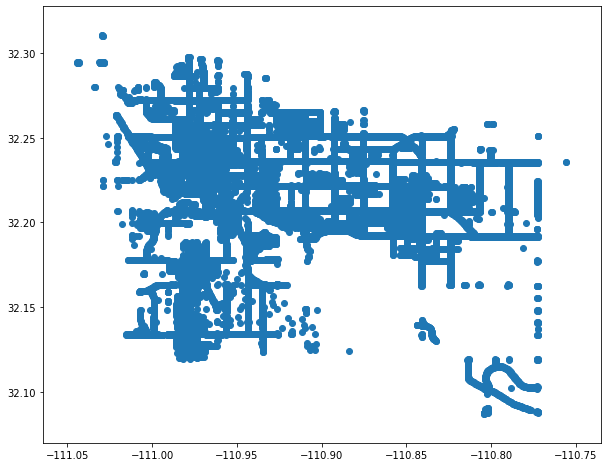

In [6]:
fig, ax = plt.subplots(figsize = (10,10))
street_lights.plot(ax=ax)
plt.show()

We are going to ultimately make a heatmap using the `Wattage` field but it is going to create some undesirable artifacts if there are any `NaN` fields (`NaN` means "not a number" for numeric fields). The `numpy` library provides a function to get a list of the indices matching a certain condition. In this case, the condition is where the fields are `NaN`. 

What will happen if we don't clean those up? When we try to create a heatmap, the function will be applied to all the values in a certain neighborhood. If that function is, say, `mean`, and it tries to take the mean of `1`, `2`, and `NaN`, the answer will also be `NaN`. We want to replace them all with `0` (you can use another realistic value if you'd like).

In [7]:
inds = np.where(street_lights['Wattage'].isnull())
inds

(array([ 1201,  5681,  6268,  6269,  6270,  6271,  6272,  6273,  6274,
         6275,  6276,  6277,  6278,  6279,  6280,  6281,  6282,  6283,
         6284,  6285,  6286,  6287,  6288,  6289,  6290,  6291,  6292,
         6293,  9385,  9386,  9387,  9388,  9389,  9390,  9391,  9392,
         9393,  9394,  9395,  9396,  9397, 10016, 10018, 10019, 10518,
        10925, 10926, 10927, 10928, 10929, 10930, 10931, 10932, 10933,
        10934, 10935, 10936, 10937, 10938, 10939, 12011, 15469, 15470,
        16086, 16087, 16088, 16089, 16090, 16091, 16092, 18305, 18307,
        18315, 19275, 19276, 19277, 19278, 19279, 20920, 21726, 21727,
        21728, 21729, 21730, 21731, 21732, 21733, 21734, 21735, 21736,
        21737, 21738, 21739, 21740, 21741, 21742, 21838, 21839, 21840,
        21841, 21846, 21847, 21848, 21849, 21852, 21853, 21854, 21855,
        21856, 21857, 21875, 21876, 21877, 21878, 21879, 21881, 21882,
        21883, 21884, 21886, 21887, 21888, 21889, 21890, 21891, 21893,
      

To see that the `Wattage` field is actually full of those `NaN` values, let's look at a slice with those indexes:

In [8]:
street_lights['Wattage'][inds[0]]

1201    NaN
5681    NaN
6268    NaN
6269    NaN
6270    NaN
         ..
22099   NaN
22100   NaN
22101   NaN
22173   NaN
22272   NaN
Name: Wattage, Length: 194, dtype: float64

This is a very common issue! `Pandas` provides a convenient way of fixing those by replacing them with a set value. Use the `fillna` function and replace the values in place. Then, print the indices of the null values afterwards as a sanity check.

In [9]:
street_lights['Wattage'].fillna(value=0, inplace = True)
inds = np.where(street_lights['Wattage'].isnull())
inds

(array([], dtype=int64),)

Great! You now have a clean street lights dataset. Our next task is to create a heat map. To do this we are going to construct an array that will contain all the raster values over our area, then create a raster from scratch based on the bounds of our street_lights data. You can experiment with different kernel shapes below and see how that affects the output. In the meantime, let's extract the spatial coordinates of the points dataset.

In [10]:
x = street_lights['Spatial_X']
y = street_lights['Spatial_Y']
minx = min(x)
maxx = max(x)
miny = min(y)
maxy = max(y)

Calculate the number of cells in the x and y direction. Since this is a geographic coordinate system and we want our cells about the same dimensions in x and y, we scale the xcount based on the cosine of the latitude of Tucson (about 0.846). If you want a raster that is more or less dense than the example below, modify the `cell_size_y` value.

In [11]:
cell_size_y=0.001
ycount = math.ceil((maxy-miny)/cell_size_y)
xcount = math.ceil(ycount/math.cos(math.radians(32.2)))
xsize = (maxx-minx)/xcount
ysize = (maxy-miny)/ycount

Brighter lights contribute more to the ambient light than softer lights so we are going to use `Wattage` to further weight for each point. 

In [12]:
weights = street_lights['Wattage'].copy()

Finally, we summarize the street lights by each grid cell, adding their weights within each cell. Since we are adding a bunch of lights in some cells and the units are `Watts`, these summary values will be quite large and not have an easily interpretable meaning. It might be something along the lines of `cumulative streetlight watts per cell`

In [13]:
h, _, _ = np.histogram2d(x, y, bins=(np.linspace(minx, maxx, xcount), np.linspace(miny, maxy, ycount)), weights=weights)
type(h)
h.shape

(264, 223)

The lights have an effect beyond the cell they reside in. We will ignore the physics about light decay and just assume that there is a local neighborhood effect and describe it by a `Gaussian` filter. You can play with different filters and different filter parameters to see how they affect the resulting heatmap. There are a _lot_ of filter options that you can read about on the (SciPy.org)[https://docs.scipy.org/doc/scipy/reference/ndimage.html] webpage.

In [14]:
z = scipy.ndimage.filters.gaussian_filter(h.T, 1)

We ran the filter. Just a sanity check to see that we still have the same type of thing

In [15]:
type(z)
z.shape

(223, 264)

The `numpy` library also has a way of easily finding the max or min of a dataset. 

In [17]:
np.amax(z)

1947.7753562521355

Don't worry! That's to be expected. Edge effects means the filter had to reach outside the source data to calcualte the new value and it filled them in with `NaN`s which, as you know, will cause the resulting function to also evaluate to `NaN`. We don't need to fix that data but we did want to see if the filter actually produced real data. `numpy` provides an alternative `max` function that ignores `NaN` since it is such a common use case.

In [19]:
np.nanmax(z)

1947.7753562521355

The next step is to construct the raster metadata for us to put the Gaussian-smoothed 2-d histogram data in. We set the `transform` which is really just the upper left coordinate and cell sizes (similar to what you get in a tif or jpg world file), the projection, the number of cells, the data type, and the number of bands.

In [20]:
transform = from_origin(minx, maxy, xsize, ysize)
meta = { 'count':1, # number of bands
         'dtype': z.dtype, # copy the data type from the filter output
         'driver': 'GTiff', # GeoTiff ftw
         'width': xcount, # number of cells
         'height': ycount, 
         'crs':rio.crs.CRS.from_dict(init='epsg:4326'), # WGS84 lat/long coordinate reference system
         'transform': transform}

Finally, write that heatmap to a file!

In [21]:
with rio.open('data/streetlights_heatmap.tif', 'w', **meta) as dst:
    dst.write(z, 1)

To get a very quick sanity check that the heatmap has believable data we'll use the `rasterio` package to load and view:

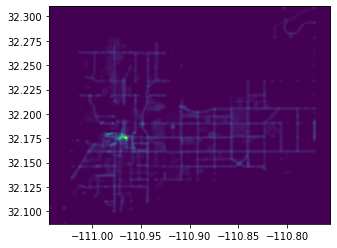

In [22]:
raster = rio.open('data/streetlights_heatmap.tif')
show(raster)

We now have a heatmap so it's time to load our second dataset, a polygon dataset. We will inspect it as well.

In [23]:
if not os.path.exists('data/nbrhoods.geojson'):
  url = 'https://opendata.arcgis.com/datasets/828d637891e94d95a2e62cf62ad2f7e0_0.geojson'
  r = requests.get(url)
  with open('data/nbrhoods.geojson', 'w') as f:
    f.write(r.content.decode("utf-8"))
    

In [24]:
nbrhoods=gpd.read_file('data/nbrhoods.geojson')
nbrhoods.head()

,OBJECTID,NAME,WARD,REGISTRATION,SCHOOL_DISTRICT,PRESIDENT,PRESIDENT_PHONE,PRESIDENT_EMAIL,VICE_PRESIDENT,VP_PHONE,...,BY_LAWS_UPDATED,URL,NBA_ID,COT_MAP_NO,COALITIONS,DATASOURCE,MAP_NO,ShapeSTArea,ShapeSTLength,geometry
0,1,A Mountain,1,11/01/84,TUSD,Peggy Williams,,Amountaincommunity@cox.net,Barbara Elfbrandt (Vice Chair),520-624-3024,...,06/15/13,https://www.tucsonaz.gov/apps/associations-and...,2,69,,NHA_CITY,None,2.458101e+07,20383.248478,"POLYGON ((-111.00763 32.20690, -111.01179 32.2..."
1,2,Aldea Linda,6,12/13/10,,Nanette M Warner,,nmwarner51@msn.com,,,...,,https://www.tucsonaz.gov/apps/associations-and...,3,193,None,NHA_CITY,None,3.624837e+06,8046.606594,"POLYGON ((-110.89229 32.21064, -110.89233 32.2..."
2,3,Alvernon Heights,5,03/24/82,TUSD,Diane M. Campbell,325-2189,,Helen Ferris,425-4457,...,01/28/02,https://www.tucsonaz.gov/apps/associations-and...,4,2,,NHA_CITY,None,2.192354e+06,6445.969849,"POLYGON ((-110.90089 32.20342, -110.90251 32.2..."
3,4,Amphi,3,09/01/97,AMPHI,Maureen Hazlett,360-7866,mhazlett@amphi.com,,,...,11/17/05,https://www.tucsonaz.gov/apps/associations-and...,5,95,,NHA_CITY,None,2.778033e+07,21124.051219,"POLYGON ((-110.96099 32.26481, -110.96099 32.2..."
4,5,Arcadia Rose,6,09/28/11,,Arlene Imoehl,977-7817,R-A-IMOEHL@cox.net,,,...,09/28/2011,https://www.tucsonaz.gov/apps/associations-and...,6,194,None,NHA_CITY,None,1.736186e+06,5271.927695,"POLYGON ((-110.88843 32.25065, -110.88840 32.2..."


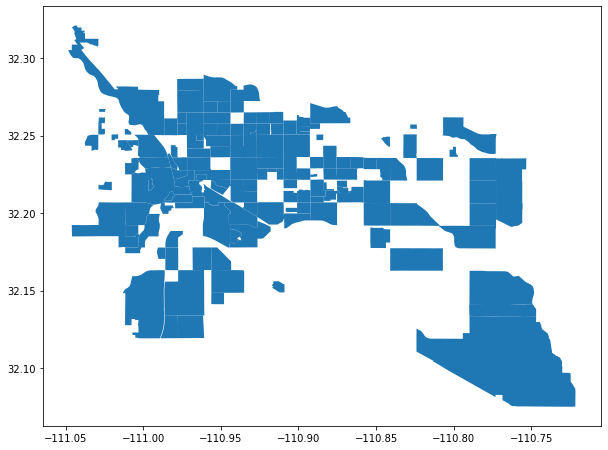

In [25]:
fig, ax = plt.subplots(figsize = (10,10))
nbrhoods.plot(ax=ax)
plt.show()

We have our final input datasets for running zonal stats. Zonal stats runs on the files. You will get a warning about `nodata` which you can safely ignore.

In [26]:
zs = zonal_stats('data/nbrhoods.geojson', 'data/streetlights_heatmap.tif')

/Users/aaryno/.pyenv/versions/3.7.1/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Inspect the zonal stats output. You will see it is an array of dictionaries.

In [27]:
zs

[{'min': 0.12919993616954578,
  'max': 166.6659552643599,
  'mean': 35.61942886459735,
  'count': 190},
 {'min': 0.0,
  'max': 0.0002889955808914903,
  'mean': 9.299771444130651e-06,
  'count': 32},
 {'min': 17.822583118995034,
  'max': 221.07965730824765,
  'mean': 83.80276492277787,
  'count': 21},
 {'min': 0.0,
  'max': 226.21203608048654,
  'mean': 41.39808743724483,
  'count': 225},
 {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'count': 12},
 {'min': 0.0,
  'max': 358.0892188030619,
  'mean': 115.38645191171622,
  'count': 74},
 {'min': 0.3998394831199259,
  'max': 248.68755816699206,
  'mean': 99.61840211314103,
  'count': 176},
 {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'count': 56},
 {'min': 62.83079837815163,
  'max': 226.77703462881996,
  'mean': 134.14971338187948,
  'count': 35},
 {'min': 12.718133107767864,
  'max': 220.42393197611085,
  'mean': 85.00931028166514,
  'count': 29},
 {'min': 83.85919667998115,
  'max': 184.97037516371847,
  'mean': 132.0241031743546,
  'count': 30},
 {'

In [28]:
type(zs)

list

In [29]:
type(zs[0])

dict

In [30]:
zs[0]

{'min': 0.12919993616954578,
 'max': 166.6659552643599,
 'mean': 35.61942886459735,
 'count': 190}

You may also recognize that there are no feature IDs in the dict. Fortunately, the stats records are in the same natural order as the records in the polygon input.

In [31]:
len(zs)

146

In [32]:
len(nbrhoods)

146

We want to add a new column to the zonal stats but it isn't as simple as the `mean`. We want to calculate the `mean` over `area`. This is also a good opportunity to point out what's called a `list comprehension`, which is a concise way of populating a list. Since the values we want are in a `dict` inside a `list` we need to extract them, or promote them to their own list. To do this:

In [33]:
light_mean = [rec['mean'] for rec in zs]

Next, let's divide the zonal mean by the polygon area to get the average light over the neighborhood.

In [34]:
light_mean_per_area = light_mean / nbrhoods.area

Finally, we can expand the `nbrhoods` `GeoDataFrame` simply by declaring a dict entry and giving it the value or our list:

In [35]:
nbrhoods['light_avg'] = light_mean_per_area

How does it look? Let's take a peek and we will set the display column to `light_avg` and let the underlying `plot` logic build a chloropleth map for us.

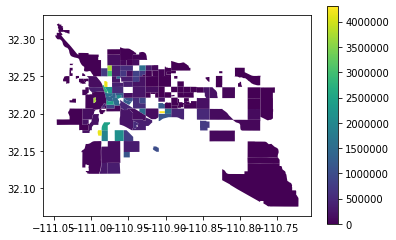

In [36]:
nbrhoods.plot(column='light_avg', legend=True)

It looks believable. Of course you can open these files in QGIS and inspect them closer, but assuming they pass the test, it's time to sort the neighborhoods based on their average light and help out your uncle with some suggestions.

In [37]:
nbrhoods.sort_values(by='light_avg', ascending=False)

,OBJECTID,NAME,WARD,REGISTRATION,SCHOOL_DISTRICT,PRESIDENT,PRESIDENT_PHONE,PRESIDENT_EMAIL,VICE_PRESIDENT,VP_PHONE,...,URL,NBA_ID,COT_MAP_NO,COALITIONS,DATASOURCE,MAP_NO,ShapeSTArea,ShapeSTLength,geometry,light_avg
2,3,Alvernon Heights,5,03/24/82,TUSD,Diane M. Campbell,325-2189,,Helen Ferris,425-4457,...,https://www.tucsonaz.gov/apps/associations-and...,4,2,,NHA_CITY,None,2.192354e+06,6445.969849,"POLYGON ((-110.90089 32.20342, -110.90251 32.2...",4.301959e+06
136,137,West Lamar,1,7/5/2016,,Margaret O. Chumbler (Contact),520-294-8367,,,,...,https://www.tucsonaz.gov/apps/associations-and...,144,62,,NHA_CITY,None,4.156622e+06,8247.728326,"POLYGON ((-110.98577 32.17784, -110.98737 32.1...",4.159970e+06
10,11,Barrio Blue Moon,3,10/18/82,TUSD,Tina Hansleben,520-409-7475,tinahansleben@gmail.com,,,...,https://www.tucsonaz.gov/apps/associations-and...,12,98,,NHA_CITY,None,3.571442e+06,8209.598517,"POLYGON ((-110.97793 32.23585, -110.97796 32.2...",4.158507e+06
87,88,Panorama Estates,1,03/03/87,TUSD,Mary Jo Ghory,520-622-6419,panoramaestatesneighborhood@gmail.com,Curtis Yingling,520-622-6419,...,https://www.tucsonaz.gov/apps/associations-and...,93,40,,NHA_CITY,None,2.086691e+06,7284.757648,"POLYGON ((-110.99501 32.21500, -110.99463 32.2...",3.770828e+06
32,33,Coronado Heights,3,06/30/09,TUSD,Donna Perry,520-276-5322,CoronadoHeightsNeighborhood@gmail.com,Berni Jilka,520-276-5322,...,https://www.tucsonaz.gov/apps/associations-and...,34,189,,NHA_CITY,None,4.853042e+06,8925.275869,"POLYGON ((-110.97613 32.26472, -110.97705 32.2...",3.735096e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,91,Poets Square,6,03/23/02,TUSD,Pete Odeven (Co-Chair),,poetssquare@gmail.com,Matt Bingham (Co-Chair),,...,https://www.tucsonaz.gov/apps/associations-and...,96,160,,NHA_CITY,None,7.101695e+06,10692.585821,"POLYGON ((-110.89238 32.22486, -110.89236 32.2...",0.000000e+00
121,122,Swan Way Park,6,,,Dan Dougherty,520-809-5466,danstarrorg410@gmail.com,,,...,https://www.tucsonaz.gov/apps/associations-and...,128,107,,NHA_CITY,None,6.997746e+06,10593.128453,"POLYGON ((-110.88404 32.23620, -110.88619 32.2...",0.000000e+00
123,124,Thunderbird Heights/Wilmot Desert Esta,6,10/07/85,TUSD,,,,David Bradley,,...,https://www.tucsonaz.gov/apps/associations-and...,130,59,,NHA_CITY,None,7.074776e+06,10595.269472,"POLYGON ((-110.85793 32.23583, -110.85819 32.2...",0.000000e+00
126,127,Udall Park,2,04/20/06,TUSD,Anne Stephenson,,wasteph@cox.net,Bob Kattnig,349-5607,...,https://www.tucsonaz.gov/apps/associations-and...,134,182,,NHA_CITY,None,2.639646e+06,7003.964974,"POLYGON ((-110.84103 32.24286, -110.84106 32.2...",0.000000e+00


To finish up, save the `nbrhoods` `GeoDataFrame` to a shapefile:

In [38]:
nbrhoods.to_file('data/nbrhoods.shp')

# Assignment Deliverable
Take a screenshot of the this final page such that it includes some output from `nbrhoods.plot(column='light_avg', legent=True` and `nbrhoods.sort_values(by='light_avg', ascending=False)`